# Métodos de Re-Muestreo 

Deseamos que los modelos que construimos tengan el mejor rendimiento posible con datos que no han "visto" previamente. En la práctica, se tiene una base de datos de cierto tamaño y esta se separa en 2 partes: $X_{train}$ y $X_{test}$ para entrenar y evaluar el modelo respectivamente. 

La manera en la que se hace esta separación puede introducir algún tipo de sego en los modelos resultantes. Las técnicas de re-muestreo sirven para controlar este sesgo, así como mejorar la estabilidad de las predicciones hechas cuando se tienen pocos datos.  

## Cross-Validation

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg">

La validación cruzada consiste en:
1. Partir la base de datos en $k$ subconjuntos de igual tamaño (si es posible).
2. Un subconjunto será $X_{test}$ y el resto se combinará para ser $X_{train}$.
3. Repetir el proceso entrenamiento-prueba cambiando la partición seleccionada para prueba.
4. Promediar las predicciones de cada una de las corridas

## Bootstrapping

<img src="http://www.drbunsen.org/static/images/posts/bootstrap/bootstrap-1.svg">

<img src="http://www.drbunsen.org/static/images/posts/bootstrap/bootstrap-2.svg">

Bootstrapping consiste en:

1. Dada una base de datos $X$ con m elementos, construir una muestra uniforme $X_i^*$ de p elementos con remplazo. 
2. Repetir el paso 1 n veces para tener $X_1^*,...,X_n^*$ muestras distintas.
3. Utilizar las distintas muestras para generar estadísticas o predicciones $\theta_1^*,...,\theta_n^*$
4. Agregar estos resultados en uno sólo.

# Decision Trees

Los árboles de decisión son algoritmos de aprendizaje supervisados que buscan predecir el valor de una variable objetivo ($Y$) en base a una serie de preguntas categóricas construidas a partir de los datos ($X$).

Tienen grandes ventajas:

- Se pueden interpretar y visualizar fácilmente.
- No requiere un gran pre-procesamiento de datos: no es necesario estandarizar, crear variables dummy, ni quitar valores faltantes (en la implementación de `sklearn` sí es necesario quitar los valores faltantes).
- Funciona con una gran variedad de datos ($X$): Discretos (Categóricos) o Contínuos (Numéricos)
- El objetivo ($Y$) también puede ser contínuo (regresión) o discreto (clasificasión).
- Pueden modificarse para trabajar en esquemas No-Supervisados (isolation forests).

Sin embargo, también tienen algunas desventajas:

- Tienden a sobre-ajustar los datos (overfitting). Hay formas de controlar esto: [tree pruning](https://en.wikipedia.org/wiki/Decision_tree_pruning) o depth limiting.
- Se sesga hacia las clases más abundantes. Se requiere que los datos estén "balanceados".
- Hay ciertos tipos de problemas en los que los árboles tienen mal rendimiento (e.g. [XOR](https://en.wikipedia.org/wiki/XOR_gate)).
- Las creación de nuevos nodos (preguntas del árbol) no suele ser la óptima debido a que sólo se optimiza localmente (se decide sólo en función del nodo actual). A sí mismo, las decisiones tomadas en las últimas preguntas pueden variar considerablemente debido a que se utilizan menos datos. Esto puede controlarse al crear un ensamble de árboles de decisión (random forest).

<img src="images/dtree_example1.png">

**Obs.**
- El órden de las preguntas en las diferentes ramas no necesariamente es el mismo.
- No es necesario que todos los caminos entre la 'raíz' y las 'hojas' tengan la misma longitud.
- Los caminos siempre descienden por el árbol hasta las hojas (hay una sola dirección).

### Construcción de un Árbol de Decisión

1. Seleccionar una variable para hacer el primer corte. Esto se hace en función de qué corte y en qué variable genere la menor "impureza", i.e. la mayor separación posible de los datos.

Formalmente, si $\theta=(j,t_m)$ es un corte hecho a un valor $t_m$ de la variable $x_j$ en el nodo $m$, podemos definir:

$$Q_{left}(\theta)=\{(x,y)|x_j \leq t_m\}$$
$$Q_{rigt}(\theta)=\{(x,y)|x_j > t_m\}$$

La impureza se calcula mediante una función $H(Q)$, de modo que:

$$G(\theta)=\frac{n_{left}}{N_m}H(Q_{left}(\theta))+\frac{n_{right}}{N_m}H(Q_{right}(\theta)),$$

donde $N_m$ es el número de datos que se evalúan en el nodo m. Se escoge:

$$\theta^*=argmin_{\theta}G(\theta)$$

<img src="images/tree_impurity2.png">

2. El proceso se repite con cada uno de los conjuntos $Q$ resultantes, hasta que se cumpla una condición:
    
    a) $N_m$ < minimum samples
    
    b) tree depth = maximum depth
    
    c) $N_m$ = 1

### Funciones de Impureza

Las funciones que se utilizan varían según el tipo de problema que se desea resolver.

**Clasificación**

Sea $\ p_{mk}=\frac{1}{N_m}\sum_{x_i \in R_m}I(y_i=k),$

donde $k$ es la etiqueta o categoría de la clasificación.


Las funciones comúnes de impureza son:

- Gini: $H(X_m)=\sum_k p_{mk}(1-p_{mk})$

- Entropía: $H(X_m)=- \sum_k p_{mk} log(p_{mk})$

- Error de Clasificación: $H(X_m)= 1 - max(p_{mk})$

**Regresión**

Las funciones comúnes de impureza son:

- Error Cuadrático Medio: $H(X_m)=\sum_{i \in N_m}(y_i - \bar{y}_i)^2$

- Error Absoluto Medio: $H(X_m)=\sum_{i \in N_m}|y_i - \bar{y}_i|^2$

### Implementación

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [49]:
type(iris)

sklearn.utils.Bunch

In [50]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [51]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [37]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [53]:
X=iris.data
y=iris.target

In [60]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Utilizaremos la función implementada en [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [39]:
DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, min_samples_split=2, min_samples_leaf=1,
                       min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
# Initialize our decision tree object
classification_tree = DecisionTreeClassifier()

# Train our decision tree (tree induction + pruning)
classification_tree = classification_tree.fit(X,y)

In [61]:
# predecir y calcular el error

y_pred=classification_tree.predict(X)

from sklearn.metrics import accuracy_score

accuracy_score(y,y_pred)

1.0

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [65]:
X_train.shape, X_test.shape, X.shape

((100, 4), (50, 4), (150, 4))

In [77]:
# implementar con validación cruzada y Gridsearch

from sklearn.model_selection import GridSearchCV

tree_grid={'criterion':['gini','entropy'],'max_depth':[2,5,7,10,15,20],'min_samples_split':[2,4,7,10,15]}

tree_regressor = GridSearchCV(DecisionTreeClassifier(),tree_grid,scoring='accuracy', cv=5)

tree_regressor.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 7, 10, 15, 20], 'min_samples_split': [2, 4, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [78]:
tree_regressor.best_score_

0.9666666666666667

In [80]:
tree_regressor.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 7}

In [82]:
tree_regressor.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Random Forests

Un bosque aleatorio o random forest es un método de ensamble. Consiste en crear una serie de árboles de decisiones a partir de los mismos datos, introduciendo una serie de variaciones en cada uno de ellos (bootstrapping y selección de variables) y agregar las predicciones de todos los árboles para tener una predicción final.

Una vez que se tienen los distintos árboles de decisiones con predicciones $Y_1,...,Y_n$ se genera la predicción final:
- En el caso de clasificación, la predicción final $Y$ es aquella con mayor frecuencia (o votos) de entre todos los árboles.
- En el caso de regresión, la predicción final $Y$ es el promedio de las predicciones de todos los árboles.

<img src="images/random_forest.png">

**Obs.**

- Se puede evaluar el rendimiento del algoritmo con elementos no utilizados en el bootstrapping (out of bag samples).


### Implementación

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, 
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, 
                       min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True,
                       oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [87]:
# implementar con validación cruzada y grid search

from sklearn.model_selection import GridSearchCV

forest_grid={'n_estimators':[1,10,100],'criterion':['gini','entropy'],'max_depth':[2,5,7,10,15,20],'min_samples_split':[2,4,7,10,15]}

forest_regressor = GridSearchCV(RandomForestClassifier(),forest_grid,scoring='accuracy', cv=5)

forest_regressor.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 10, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 7, 10, 15, 20], 'min_samples_split': [2, 4, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [88]:
forest_regressor.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 10}

In [89]:
forest_regressor.best_score_

0.9666666666666667

In [93]:
forest_regressor.best_estimator_.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

# Regresiones

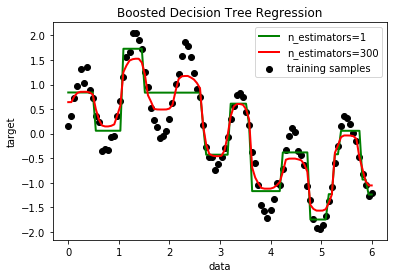

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = RandomForestRegressor(max_depth=4,n_estimators=300)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

# Isolation Forests

Son una modificación de Random Forest. Buscan 'aislar' datos atípicos y asignarles un 'score' de anomalía. Consiste en:

1. Seleccionar un punto $x_i$ en la base de datos $X$
2. Seleccionar de manera aleatoria una variable de la base de datos $X$.
3. Crear de manera aleatoria una división de los valores de la variable seleccionada (entre el mínimo y el máximo).
4. Fijarse en la región del espacio que contiene al punto, formada por la partición del paso 3. Si el punto $x_i$ es el único en esa región, se aisló completamente. Si hay otros puntos en la región, se repiten los pasos 2 y 3 hasta que el punto se encuentre aislado.

**Obs.** 
- La partición recurrente creada hasta ahora puede interpretarse como un árbol de decisión, en donde el número de divisiones necesarias para aislar un punto equivalen a la distancia entre la "raíz" y las "hojas". Esto se puede usar para construir un 'score' de anomalía y decidir si el punto es atípico o no.  
- En práctica se hace una misma sere de cortes y se evalúan todos los puntos con el mismo conjunto de cortes.

5.Se genera una serie de árboles de decisiones usando los pasos 1 a 4 y se agrean en un bosque aleatorio.


**Obs:** 
- Es un algoritmo No Supervisado.
- Los datos atípicos se consideran aquellos que requieren el menor número de divisiones para aislarse.
- Esto puede generalizarse, por ejemplo realizando los cortes a diferentes ángulos.

<img src="https://cdn-images-1.medium.com/max/800/1*ujfv7WJH-tL1cRLxYEoicg.png">

En esta ocasión implementaremos la función de Sci-Kit Learn. Esta utiliza la siguiente función para dar el 'score' de la anomalía:

<img src="https://cdn-images-1.medium.com/max/800/1*Zha5PJSauUmig8gstAjflg.png">

- h(x) es la longitud del camino entre la "raiz" y la "hoja" para cada observación en un árbol específico.
- E(h(x)) es el valor esperado que se calcular con todos los árboles en el ensamble.
- n es el número de nodos "hoja".
- c(n) es la longitud del camino raiz-hoja promedio para un árbol de n "hojas" (según la teoría de BST)

**Obs.**
- Si $s$ es cerano a 1, el dato será anómalo
- Si $s$ es menor a 0.5, el dato es normal
- Si $s$ es cercano a 0.5, no se tiene una distinción clara

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

# Generar datos

rng = np.random.RandomState(42)

# Generar datos de entrenammiento "normales"
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train] #duplica los datos y añade un offset de 3 a los originales
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Generar más datos "normales" (con la misma distribución). Se usarán para prueba 
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Generar outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

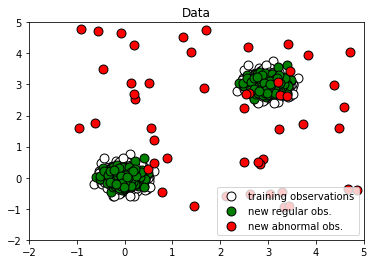

In [95]:
# graficar datos
plt.title("Data")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',s=20*4, edgecolor='k')


plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["training observations",
            "new regular obs.", "new abnormal obs."],
           loc="lower right")

# saving the figure
plt.savefig('generated_data.png', dpi=300)
plt.show()

In [10]:
IsolationForest(n_estimators=100, max_samples="auto", contamination="auto", max_features=1.0, 
                bootstrap=False, n_jobs=None, behaviour="old", random_state=None, verbose=0)

In [14]:
# Isolation Forest ----

# training the model
isoforest = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng)
isoforest.fit(X_train)

# predictions
y_pred_train = isoforest.predict(X_train)
y_pred_test = isoforest.predict(X_test)
y_pred_outliers = isoforest.predict(X_outliers)

y_pred_train

/home/arturo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/arturo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/arturo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/arturo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


array([1, 1, 1, ..., 1, 1, 1])

In [97]:
y_pred_outliers

array([-1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [96]:
y_pred_test

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1

In [98]:
print("Test Accuracy para datos normales:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("Test Accuracy para datos atípicos:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Test Accuracy para datos normales: 0.925
Test Accuracy para datos atípicos: 0.96


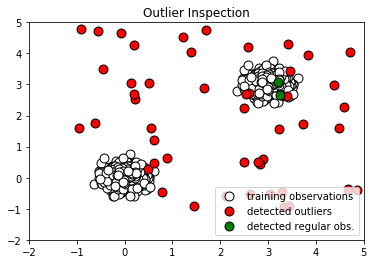

In [99]:
# adding the predicted label
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Outlier Inspection")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["training observations",
            "detected outliers", 
            "detected regular obs."],
           loc="lower right")

# saving the figure
plt.savefig('outlier_inspection.png', dpi=300)

plt.show()

# Referencias

- [Khan Academy: Information Entropy](https://www.khanacademy.org/computing/computer-science/informationtheory/moderninfotheory/v/information-entropy)
- [Dr. Bunsen: Bootstrap in Picture](http://www.drbunsen.org/bootstrap-in-picture/)
- [Sci-Kit Learn Documentation: Desicion Trees](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)
- [Josh Starmer: Filling Missing Data and Clustering via Random Forests](https://www.youtube.com/watch?v=nyxTdL_4Q-Q)
- [Towards Data Science: Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)